# Features and Modeling Dec 30, 2017

In [1]:
# Import modules

import pandas as pd
import numpy as np
import os
import sys
import math
import pickle
import random
import re
import json
import datetime

import sqlite3

from dateutil.parser import parse

import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
#import colorlover as cl
from IPython.display import Image

src_dir = os.path.join(os.getcwd(), os.pardir,'src')
sys.path.append(src_dir)

import load_data as ld
import features as fe
import models as me

init_notebook_mode(connected=True)

%reload_ext autoreload
%autoreload 2

In [4]:
#data_dir = 'C:\\Users\\Colleen\\Documents\\Kaggle Corporacion\\raw_data' 
data_dir = 'D:\Kaggle Data\Corporacion'
db_loc = data_dir
db_name = 'kaggle_corporacion_db'
db_f_name = os.path.join(data_dir, ld.DB_NAME)

In [5]:
# Load data from 2013
train_data_2013 = ld.get_year_data(db_loc, 2013)

# Load data from 2014
train_data_2014 = ld.get_year_data(db_loc, 2014)

In [6]:
# Get other data

other_data = ld.get_other_data(data_dir)
label_encoders = fe.fit_label_encoders(other_data)

In [ ]:
feats = fe.get_features(train_data_2013, other_data, label_encoders)

In [74]:
test_feats = fe.get_features(train_data_2014.iloc[0:100,:], stores, items, oil, holidays)

In [101]:
# Encode string variables

from sklearn.preprocessing import LabelEncoder

enc_feats = feats.copy()

le_item_family = LabelEncoder()
le_item_family.fit(np.unique(list(items['item_family']) + list(feats['item_family']) + list(test_feats['item_family'])))

le_store_city = LabelEncoder()
le_store_city.fit(np.unique(list(stores['store_city'])))

le_store_state = LabelEncoder()
le_store_state.fit(np.unique(list(stores['store_state'])))

le_store_type = LabelEncoder()
le_store_type.fit(np.unique(list(stores['store_type'])))

enc_feats['item_family'] = le_item_family.transform(feats['item_family'])
enc_feats['store_city'] = le_store_city.transform(feats['store_city'])
enc_feats['store_state'] = le_store_state.transform(feats['store_state'])
enc_feats['store_type'] = le_store_type.transform(feats['store_type'])



In [91]:
# Fill missing oil prices by interpolation

enc_feats = enc_feats.interpolate()
enc_feats['dcoilwtico'].iloc[0] = enc_feats['dcoilwtico'].iloc[1]

In [102]:
del enc_feats['id']
train_y = enc_feats['unit_sales']
del enc_feats['unit_sales']
del enc_feats['dcoilwtico']

In [107]:
# Get test feats
test_feats = fe.get_features(train_data_2014.iloc[0:100,:], stores, items, oil, holidays)

enc_test_feats = test_feats.copy()

enc_test_feats['item_family'] = le_item_family.transform(test_feats['item_family'])
enc_test_feats['store_city'] = le_store_city.transform(test_feats['store_city'])
enc_test_feats['store_state'] = le_store_state.transform(test_feats['store_state'])
enc_test_feats['store_type'] = le_store_type.transform(test_feats['store_type'])

del enc_test_feats['dcoilwtico']
del enc_test_feats['id']

test_y = test_feats['unit_sales']
del enc_test_feats['unit_sales']

#test_feats = test_feats.interpolate()


In [105]:
enc_feats.columns

Index([u'store_nbr', u'item_nbr', u'onpromotion', u'date_year', u'date_month',
       u'date_day', u'store_city', u'store_state', u'store_type',
       u'store_cluster', u'item_family', u'item_class', u'item_perishable',
       u'is_holiday', u'is_event'],
      dtype='object')

In [108]:
enc_test_feats.columns

Index([u'store_nbr', u'item_nbr', u'onpromotion', u'date_year', u'date_month',
       u'date_day', u'store_city', u'store_state', u'store_type',
       u'store_cluster', u'item_family', u'item_class', u'item_perishable',
       u'is_holiday', u'is_event'],
      dtype='object')

In [109]:
# hot encode features

from sklearn.preprocessing import OneHotEncoder

cat_vars = np.array(['store_nbr', 'item_nbr', 'date_month', 'store_city', 'store_state',
       'store_type', 'store_cluster', 'item_family', 'item_class'])
all_vars = np.array(enc_feats.columns)
enc = OneHotEncoder(categorical_features = [np.where(all_vars == x)[0][0] for x in cat_vars])
enc_feats = enc.fit_transform(enc_feats)

In [110]:
enc_test_feats = enc.transform(enc_test_feats)

In [111]:
# Fit a linear regression model

from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(enc_feats, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [112]:
res = regr.predict(enc_test_feats)

In [121]:
res = [0 if x < 0 else x for x in res]

In [124]:
iplot([go.Scatter(x=range(len(res)), y=res, name='pred'), go.Scatter(x=range(len(res)), y=test_y, name='actual')])

In [123]:
# Get error

me.get_error(res, test_y, test_feats['item_perishable'])

0.82330655878272074

In [126]:
# Residual plot

iplot([go.Scatter(y=[test_y[i] - res[i] for i in range(len(test_y))], x = res, mode='markers')])

((array([-2.46203784, -2.12570747, -1.93122778, -1.79044653, -1.67819304,
         -1.58381122, -1.50174123, -1.42869743, -1.36256869, -1.30191411,
         -1.24570419, -1.19317644, -1.14374949, -1.09696931, -1.05247413,
         -1.00997067, -0.96921765, -0.93001393, -0.89218993, -0.85560121,
         -0.82012357, -0.78564937, -0.75208458, -0.71934648, -0.68736185,
         -0.65606548, -0.62539893, -0.59530962, -0.56574992, -0.53667655,
         -0.50804994, -0.47983378, -0.45199463, -0.42450149, -0.39732558,
         -0.37044003, -0.34381966, -0.31744076, -0.29128096, -0.26531902,
         -0.23953472, -0.21390872, -0.18842244, -0.16305799, -0.13779803,
         -0.1126257 , -0.08752455, -0.06247843, -0.03747145, -0.01248789,
          0.01248789,  0.03747145,  0.06247843,  0.08752455,  0.1126257 ,
          0.13779803,  0.16305799,  0.18842244,  0.21390872,  0.23953472,
          0.26531902,  0.29128096,  0.31744076,  0.34381966,  0.37044003,
          0.39732558,  0.42450149,  0.

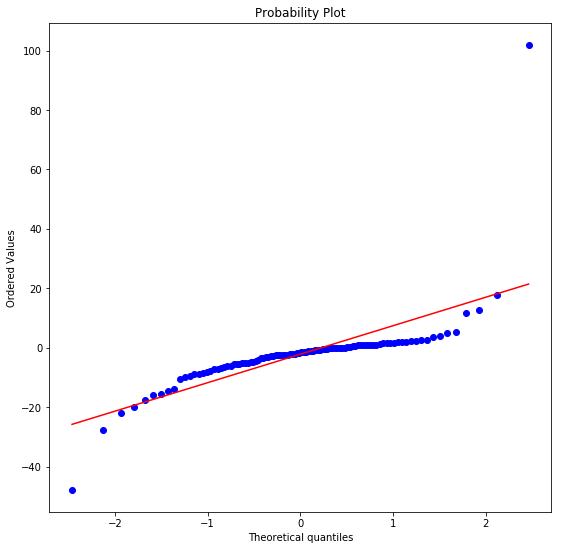

In [130]:
# QQ plot

%matplotlib inline

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))

stats.probplot([test_y[i] - res[i] for i in range(len(test_y))], dist="norm", plot=plt)